# Exploratory challenge

Our research question:

Are there periodic and seasonal trends (e.g., winter, summer), and how can we model
them?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

f=pd.read_csv("Trips_2018.csv")

# start with dropping the column Unnamed: 0
f.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [2]:
# Now let's adjust the data 
f['starttime']=pd.to_datetime(f['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
f['stoptime']=pd.to_datetime(f['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
f['usertype']=pd.Categorical(f['usertype'])
f['gender']=pd.Categorical(f['gender'])
f['start_station_id']=pd.Categorical(f['start_station_id'])
f['end_station_id']=pd.Categorical(f['end_station_id'])
# Add columns with month, and weekday name
f['Month'] = f['starttime'].dt.month
f['Weekday Name'] = f['starttime'].dt.day_name()


bad_idx = f.index[f.isna().any(axis=1)]
#print(bad_idx.tolist())
rows_with_na = f[f.isna().any(axis=1)]
#print("rows_with_na first", rows_with_na)

f = f.dropna()


The seasons in NYC are: 

Winter : Dec - Feb

Spring: March - May

Summer: June - August

Fall: September - November

Let's start with visualising how the amount of trips are taken each day.

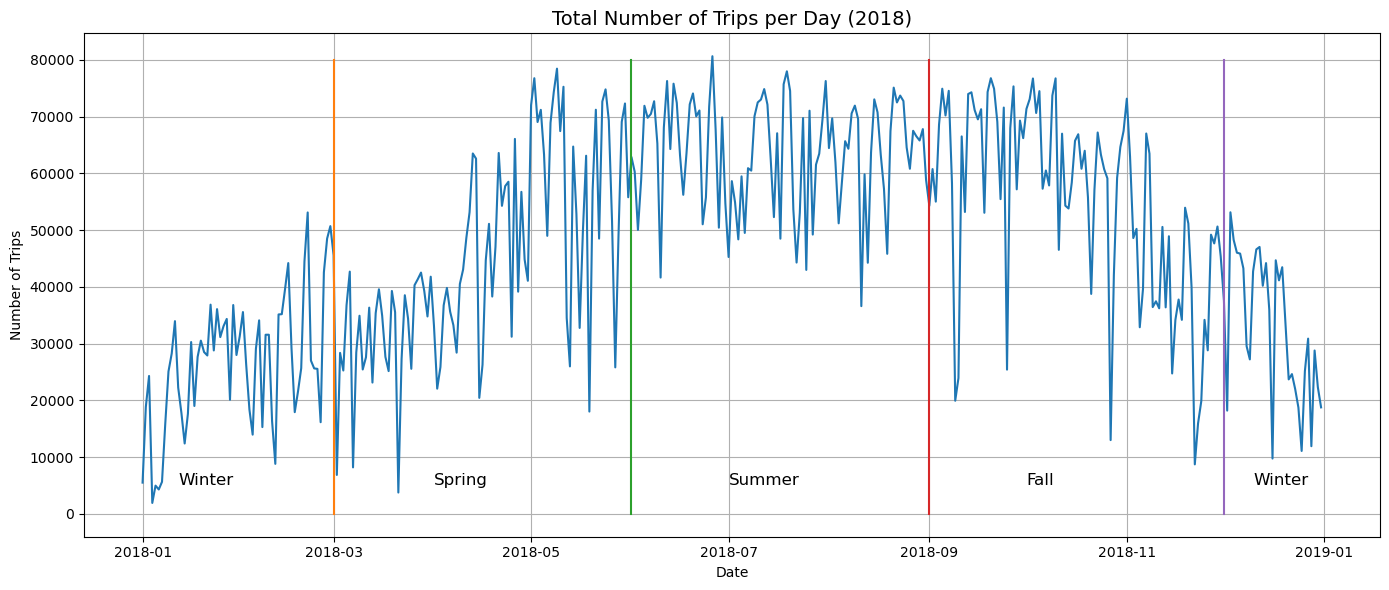

In [3]:
# Count how many trips start on each day
# Start with setting the starttime as the index
f = f.set_index('starttime')
# Then add trip number to each date     
daily_counts = f.resample('D').size()  # 'D'=daily frequency

# Plot
plt.figure(figsize=(14,6))
plt.plot(daily_counts.index, daily_counts.values, linewidth=1.5)
plt.title("Total Number of Trips per Day (2018)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()

# according to the seasons, let's visualize it with verticle lines and titles
plt.annotate('Winter', xy=(pd.Timestamp('2018-01-12'), 5000), xytext=(pd.Timestamp('2018-01-12'), 5000), fontsize=12)
plt.plot([pd.Timestamp('2018-03-01'), pd.Timestamp('2018-03-01')], [0, 80000])
plt.annotate('Spring', xy=(pd.Timestamp('2018-04-01'), 5000), xytext=(pd.Timestamp('2018-04-01'), 5000), fontsize=12)
plt.plot([pd.Timestamp('2018-06-01'), pd.Timestamp('2018-06-01')], [0, 80000])
plt.annotate('Summer', xy=(pd.Timestamp('2018-07-01'), 5000), xytext=(pd.Timestamp('2018-07-01'), 5000), fontsize=12)
plt.plot([pd.Timestamp('2018-09-01'), pd.Timestamp('2018-09-01')], [0, 80000])
plt.annotate('Fall', xy=(pd.Timestamp('2018-10-01'), 5000), xytext=(pd.Timestamp('2018-10-01'), 5000), fontsize=12)
plt.plot([pd.Timestamp('2018-12-01'), pd.Timestamp('2018-12-01')], [0, 80000])
plt.annotate('Winter', xy=(pd.Timestamp('2018-12-10'), 5000), xytext=(pd.Timestamp('2018-12-10'), 5000), fontsize=12)
plt.show()

We see a obvious trend

Bikes are more frequently used during the summer months

We have non-stationary mean and non-stationary variance



In [4]:
# function to attach a month to a season according to the NYC seasons
def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

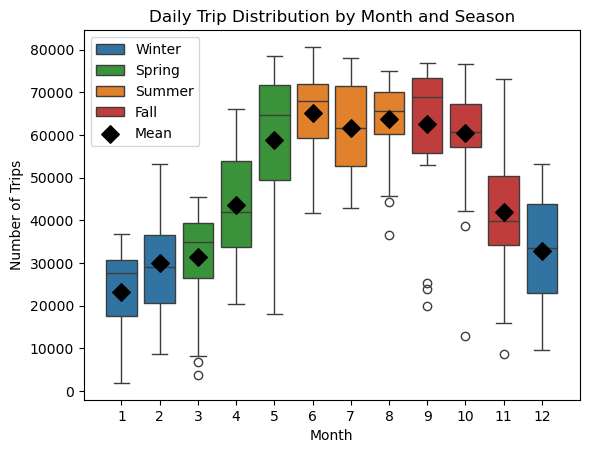

In [5]:
#Let's use boxplot to visualize for the months

daily_counts_df = (daily_counts.reset_index().rename(columns={"starttime": "date", 0: "trips"}))
daily_counts_df = daily_counts_df.sort_values("date").set_index("date")

# Add new columns of day of year, month, weekday and the season for each day
daily_counts_df["doy"] = daily_counts_df.index.dayofyear
daily_counts_df["month"] = daily_counts_df.index.month
daily_counts_df["weekday"] = daily_counts_df.index.dayofweek
daily_counts_df["season"] = daily_counts_df["month"].apply(month_to_season)

# for nice seperation between seasons they each get their own colour
season_colors = {
    "Winter": "#1f77b4",   # Blue
    "Spring": "#2ca02c",   # Green
    "Summer": "#ff7f0e",   # Orange
    "Fall":   "#d62728"    # Red
}

# Now we find the mean for each month
monthly_means = daily_counts_df.groupby("month")["trips"].mean()

sns.boxplot(
    data=daily_counts_df,
    x='month',
    y='trips',
    hue='season',
    palette=season_colors,
    dodge=False,
    linewidth=1
)

# Overlay the boxplot with the mean values
plt.scatter(
    x=monthly_means.index-1,
    y=monthly_means.values,
    color='black',
    s=80,
    zorder=10,
    marker='D',
    label='Mean'
)

plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.title("Daily Trip Distribution by Month and Season")

plt.legend()
plt.show()


These boxplots confirm seasonality that we saw in the first plots. 

The low outliers are presumably during days with really bad weather which is not our challenge so we won't focus on that.

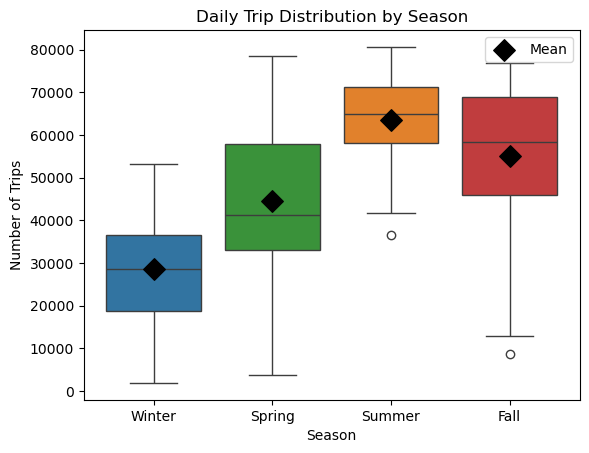

In [6]:
# now we find the mean of each season

seasonal_means = daily_counts_df.groupby("season")["trips"].mean()
# Explicit order since in our data the Winter season splits from beginning of the year and the end
season_order = ["Winter", "Spring", "Summer", "Fall"]

# Let's use boxplot to visualize for the seasons now
sns.boxplot(
    data=daily_counts_df,
    x='season',
    y='trips',
    hue='season',
    palette=season_colors,
    order=season_order,
    dodge=False,
    linewidth=1
)

# Convert the means to match the order of seasons
x_positions = range(len(season_order))
means_in_order = [seasonal_means[s] for s in season_order]

# Overlay the boxplot with the mean values
plt.scatter(
    x=x_positions,
    y=means_in_order,
    color='black',
    s=120,
    marker='D',
    zorder=10,
    label="Mean"
)

plt.xlabel("Season")
plt.ylabel("Number of Trips")
plt.title("Daily Trip Distribution by Season")

plt.legend()
plt.show()

In [ ]:
# Let's find the trend for different seasonalities to plot
daily_counts_5d = daily_counts_df["trips"].rolling(5, center=True, min_periods=2).mean()
daily_counts_7d = daily_counts_df["trips"].rolling(7, center=True, min_periods=2).mean()
daily_counts_14d = daily_counts_df["trips"].rolling(14, center=True, min_periods=2).mean()
daily_counts_30d = daily_counts_df["trips"].rolling(30, center=True, min_periods=2).mean()



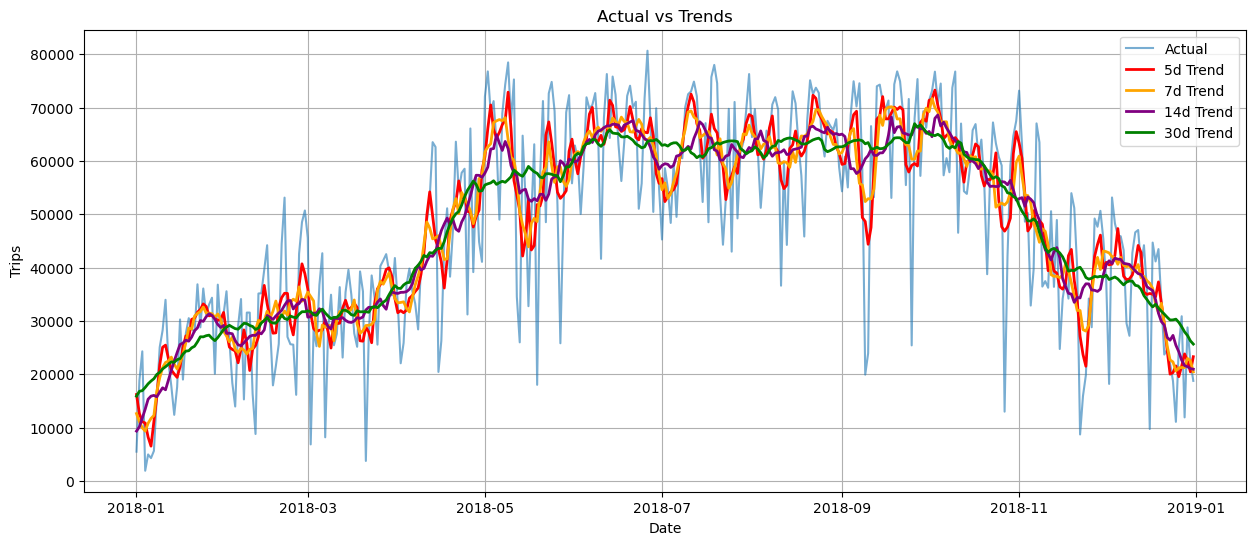

In [8]:
# Actual vs Trends
plt.figure(figsize=(15,6))
plt.plot(daily_counts_df.index, daily_counts_df["trips"], label="Actual", alpha=0.6)
plt.plot(daily_counts_df.index, daily_counts_5d, label="5d Trend", color="red", linewidth=2)
plt.plot(daily_counts_df.index, daily_counts_7d, label="7d Trend", color="orange", linewidth=2)
plt.plot(daily_counts_df.index, daily_counts_14d, label="14d Trend", color="purple", linewidth=2)
plt.plot(daily_counts_df.index, daily_counts_30d, label="30d Trend", color="green", linewidth=2)
plt.title("Actual vs Trends")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Let's run the augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_counts_df['trips'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.534609
p-value: 0.516327
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Next three functions are from the lecture notebook from week 9.

In [10]:
from sklearn.metrics import r2_score, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
def print_stats(y_test, y_preds, title="You forgot the title!"):
    print(title+": ")
    print("\tr^2=%f"%r2_score(y_test,y_preds))
    print("\tMAE=%f"%mean_absolute_error(y_test,y_preds))
    print("\tMAPE=%f"%mean_absolute_percentage_error(y_test,y_preds))

In [12]:
def timeseries_train_test_split_indexes(ts, test_size):
   
    # get the index after which test set starts
    split_time = int(len(ts)*(1-test_size))
    
    test_index=ts.iloc[split_time:].index[0]
    
    return ts.index<test_index, ts.index>=test_index

From the results above we want to test ARIMA model and Gradient Boosting and test which performs better. 

In [ ]:
# start with copying the data
data = daily_counts_df.copy()
data = data.sort_index()

# for simplification 
data["y"] = data["trips"] # always just modelling trips amount y

# season feature (categorical strings --> numeric codes)
data["season"] = data["season"].astype("category").cat.codes

# lag features to data columns
MAX_LAG = 21
for lag in range(1, MAX_LAG + 1):
    data[f"lag_{lag}"] = data["y"].shift(lag)

# rolling windows to data columns
data["roll7"] = data["y"].rolling(7).mean()
data["roll14"] = data["y"].rolling(14).mean()
data["roll30"] = data["y"].rolling(30).mean()
data["roll7std"] = data["y"].rolling(7).std()

# drop rows with missing lag/roll data
data = data.dropna()

# again copy the now transformed data as a training + test set
ts = data["y"].copy()


In [ ]:
# Split data into train and test for ARIMA

# Get the indexes for test and train as a boolean array
train_idx, test_idx = timeseries_train_test_split_indexes(ts, 0.2)

train_data = ts[train_idx]
test_data  = ts[test_idx]


In [ ]:
# Walking forward function for the modelling
def walk_forward_forecast(data, train_idx, test_idx, model, feature_cols):
    test_pos = np.asarray(test_idx)
    if test_pos.dtype == bool:  
        test_pos = np.where(test_pos)[0] 

    preds = []
    actuals = []

    for i in test_pos:

        # data up to current test time
        extract = data.iloc[:i+1].copy()

        # train end = previous day
        train_extract = extract.iloc[:-1]

        y_train = train_extract["y"]
        X_train = train_extract[feature_cols]

        # prediction input: last row
        X_last = extract[feature_cols].iloc[-1:].values

        # fit + predict
        model.fit(X_train, y_train)
        pred = model.predict(X_last)[0]

        preds.append(pred)
        actuals.append(data["y"].iloc[i])

    return np.array(actuals), np.array(preds)

In [16]:
feature_cols = [
    "weekday", "month", "doy", "season",
    "roll7", "roll14", "roll30", "roll7std"
] + [f"lag_{lag}" for lag in range(1, MAX_LAG + 1)]


In [17]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA to training period only
arima_model = ARIMA(train_data, order=(1,1,2))
arima_fit = arima_model.fit()

# Forecast over the entire test range
arima_forecast = arima_fit.forecast(steps=len(test_data))

print_stats(test_data, arima_forecast, title=f"ARIMA Evaluation")


ARIMA Evaluation: 
	r^2=-2.077218
	MAE=23008.297525
	MAPE=0.996107


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


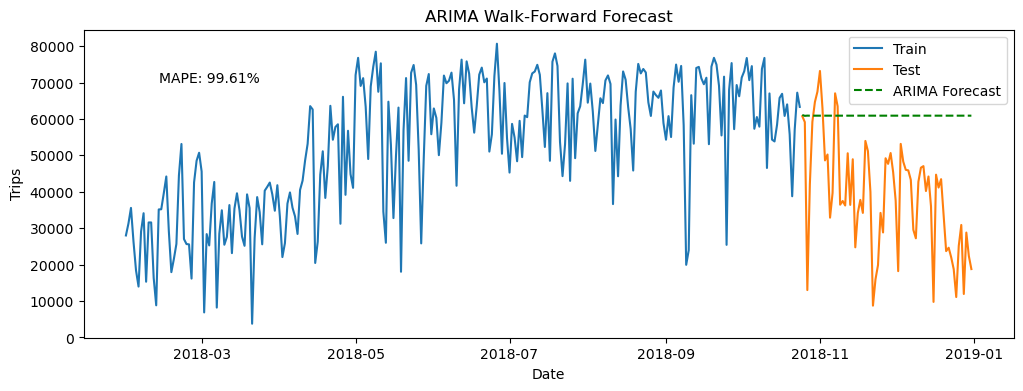

In [25]:
# Plot the Forecast VS test data
mape_value = mean_absolute_percentage_error(test_data, arima_forecast) * 100

plt.figure(figsize=(12,4))
plt.plot(train_data.index, train_data, label="Train")
plt.plot(test_data.index, test_data, label="Test")
plt.plot(test_data.index, arima_forecast, label="ARIMA Forecast", linestyle="--", color="green")
plt.annotate(f"MAPE: {mape_value:.2f}%", xy=(pd.Timestamp('2018-02-12'), 70000), xytext=(pd.Timestamp('2018-02-12'), 70000), fontsize=10)


plt.title("ARIMA Walk-Forward Forecast")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.show()


In [19]:
# Split data into train and test for rest

train_idx, test_idx = timeseries_train_test_split_indexes(data["y"], 0.2)

train_data = ts[train_idx]
test_data  = ts[test_idx]

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()

y_test_gb, y_pred_gb = walk_forward_forecast(data, train_idx, test_idx, gb_model, feature_cols)

print_stats(y_test_gb, y_pred_gb, title=f"Gradient Boosting Evaluation")



/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packa

Gradient Boosting Evaluation: 
	r^2=0.345581
	MAE=9596.384692
	MAPE=0.384214


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


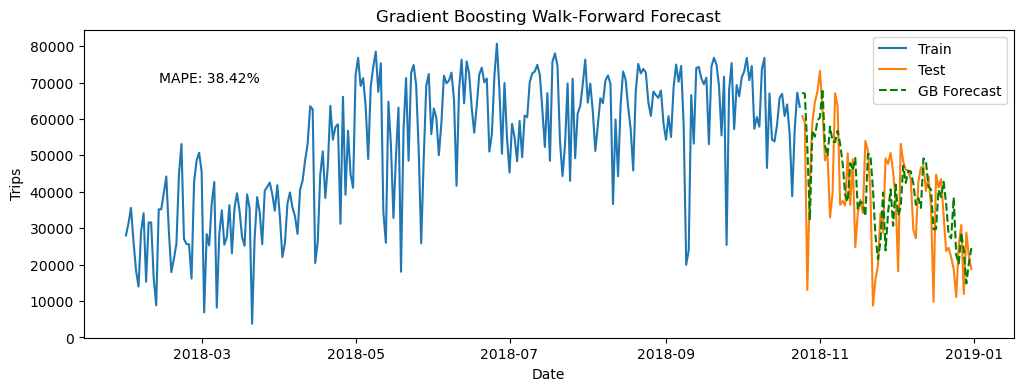

In [26]:
# Plot the Forecast VS test data
mape_value = mean_absolute_percentage_error(y_test_gb, y_pred_gb) * 100

plt.figure(figsize=(12,4))
plt.plot(train_data.index, train_data, label="Train")
plt.plot(test_data.index, y_test_gb, label="Test")
plt.plot(test_data.index, y_pred_gb, label="GB Forecast", linestyle="--", color="green")
plt.annotate(f"MAPE: {mape_value:.2f}%", xy=(pd.Timestamp('2018-02-12'), 70000), xytext=(pd.Timestamp('2018-02-12'), 70000), fontsize=10)

plt.title("Gradient Boosting Walk-Forward Forecast")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.show()

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=14,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=42
)

y_test_rf, y_pred_rf = walk_forward_forecast(data, train_idx, test_idx, rf_model, feature_cols)

print_stats(y_test_rf, y_pred_rf, title=f"Random Forest Evaluation")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:

Random Forest Evaluation: 
	r^2=0.373101
	MAE=9085.044928
	MAPE=0.392898


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


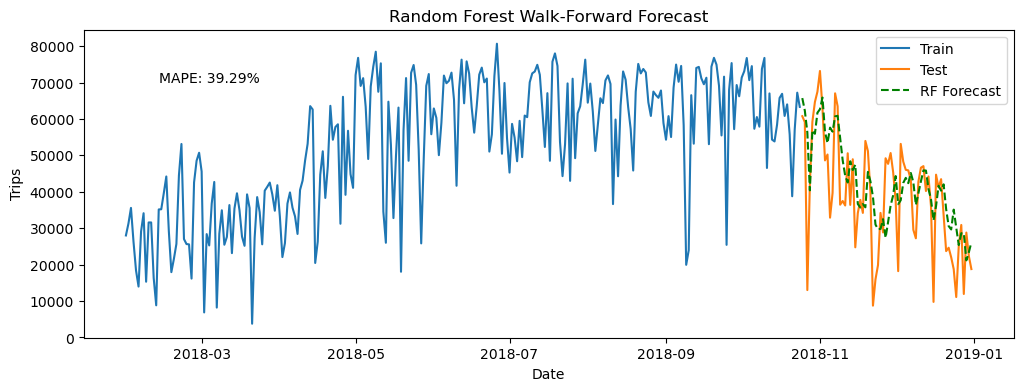

In [27]:
# Plot the Forecast VS test data
mape_value = mean_absolute_percentage_error(y_test_rf, y_pred_rf) * 100

plt.figure(figsize=(12,4))
plt.plot(train_data.index, train_data, label="Train")
plt.plot(test_data.index, y_test_rf, label="Test")
plt.plot(test_data.index, y_pred_rf, label="RF Forecast", linestyle="--", color="green")
plt.annotate(f"MAPE: {mape_value:.2f}%", xy=(pd.Timestamp('2018-02-12'), 70000), xytext=(pd.Timestamp('2018-02-12'), 70000), fontsize=10)


plt.title("Random Forest Walk-Forward Forecast")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.show()